In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Circle
from matplotlib.patches import Wedge

In [2]:
def dipole_polar(r, theta):
    """calculate dipole magnetic field from given coordinate

    Args:
        r (float): radial coord position in units [km]
        theta (float): angular coord position in units [deg]

    Returns:
        float: radial and azimuthal components at dipole B-field
    """
    
    RE = 6370                   # radius of earth [km]
    c0 = -BE*(RE/r)**3          # coeff. for simplification
    
    # calclate B-field components
    Br  = c0*2*np.cos(theta)    # radial component of B
    Bth = c0*np.sin(theta)      # azimuthal component of B
    
    return Br, Bth

def vectorTransform_cartesian2D(vr, vtheta, r, theta):
    """vector transform to 2D cartesian coordinates
    
    """
    
    vx = vr*np.cos(theta)-vtheta*np.sin(theta) # x-coord
    vy = vr*np.sin(theta)+vtheta*np.cos(theta) # y-coord
    
    return vx, vy


In [3]:
def draw_earth(ax, rad=1, angle=0, polar=False, **kwargs):
    """
    A handy function for drawing dayside/nightside Earth on either cartesian or polar axis.
    (c) M. Argall

    Args:
        ax (axis): current axis
        rad (float): radius of projected Earth. If units [RE], use 1. Defaults to 1.
        angle (int, optional): rotation in [deg]. Defaults to 0.
        polar (bool, optional): choice of prjection on cartesian (False) or polar (True) axis. Defaults to False.
    """
    
    theta1 = 90 + angle
    theta2 = 270 + angle
        
    # plot on cartesian axis
    if polar==False:
        
        loc = (0,0)
        
        # create semicircles
        dayside   = Wedge(loc, rad, theta1, theta2, facecolor='w', edgecolor='k', **kwargs)
        nightside = Wedge(loc, rad, theta2, theta1, facecolor='k', edgecolor='k', **kwargs)
        
        # plot 
        ax.add_artist(dayside)
        ax.add_artist(nightside)
        
    # plot on polar axis
    else:
        # fill color
        ax.fill_between(np.linspace(-np.radians(theta1), np.radians(theta1), 30), 0, np.ones(30)*rad, color='k', **kwargs)
        ax.fill_between(np.linspace(np.radians(theta1), np.radians(theta2), 30), 0, np.ones(30)*rad, color='w', **kwargs)
        
        # outline
        ax.plot(np.linspace(np.radians(theta1), np.radians(theta2), 30), np.ones(30)*rad, color='k', **kwargs)
        ax.plot(np.linspace(-np.radians(theta1), np.radians(theta1), 30), np.ones(30)*rad, color='k', **kwargs)

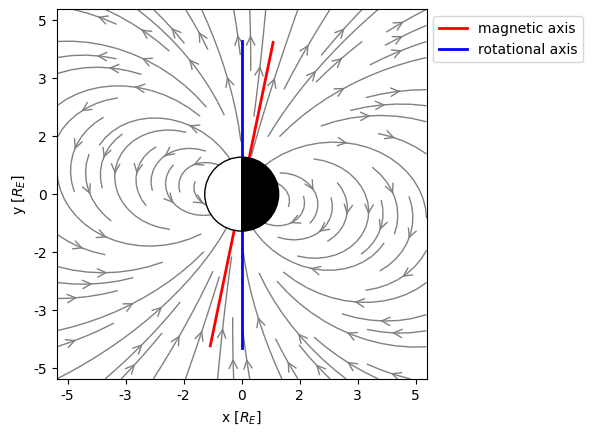

In [4]:
'''
Earth Dipole Field Model
'''

BE = 3.12e-5            # mag. field strength at surface of earth [T]
RE = 6370               # radius of earth [km]
tilt = np.radians(11.7) # tilt of magnetic axis [rad]
adj = np.pi/2 + tilt    # plot correction 

# parameters
dn   = 1000
nmax = 5*RE
n    = np.linspace(-nmax, nmax, dn)

# create grid
x, y = np.meshgrid(n,n)
r = np.sqrt(x**2+y**2)
theta = np.arctan2(y, x)

# adjusted theta for Earth's tilt
theta_adj = [x+adj for x in theta]

# calculate dipole field 
Br, Btheta = dipole_polar(r, theta_adj)

# transform to cartesian coordinates
Bx, By = vectorTransform_cartesian2D(Br, Btheta, r, theta)

# magnetic axis
magscale = 0.17
magaxis_x = np.linspace(-nmax*magscale, nmax*magscale,dn)
magaxis_y = np.tan(-adj)*magaxis_x

# rotational axis
rotscale = magscale-1.
rotaxis_x = np.zeros(dn)
rotaxis_y = np.linspace(-nmax*rotscale, nmax*rotscale,dn)

# plot
fig, ax = plt.subplots()

mag = np.sqrt(Bx**2+By**2)
#ax.contour(x,y,mag, 20)
ax.streamplot(x, y, Bx, By, color='grey', linewidth=1, density=.8, arrowstyle='->', arrowsize=1.5)

ax.plot(magaxis_x, magaxis_y, c='r', linewidth=2, label = 'magnetic axis')
ax.plot(rotaxis_x, rotaxis_y, c='b', linewidth=2, label = 'rotational axis')

# scale axis by RE
scale = ticker.FuncFormatter(lambda x, pos: '{0:.0f}'.format(x/RE))
ax.xaxis.set_major_formatter(scale)
ax.yaxis.set_major_formatter(scale)


# Add a filled circle for the Earth; make sure it's on top of the streamlines.
draw_earth(ax, RE, zorder=10)
#ax.add_patch(Circle((0,0), RE, color='k', zorder = 10))
ax.set_aspect('equal')

ax.set_xlabel("x [$R_E$]")
ax.set_ylabel("y [$R_E$]")
ax.legend(loc='upper left', ncol=1, bbox_to_anchor=(1, 1))

# save figure
save_name = 'plot_2d_dipole_bfield'
plt.savefig('../bin/'+save_name+'.png',bbox_inches='tight', dpi=400)